In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
import healpy as hp

from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/desi-examples/imaging_systematics'))
from plot_healpix_map import plot_map

sys.path.append(os.path.expanduser('~/git/desi-targets/useful'))
from isdes import get_isdes

256 Healpix size = 0.05246 sq deg
381257
Area = 17032.9 sq deg
0.8277334897916342
maps 307551
Done! 00:00:02


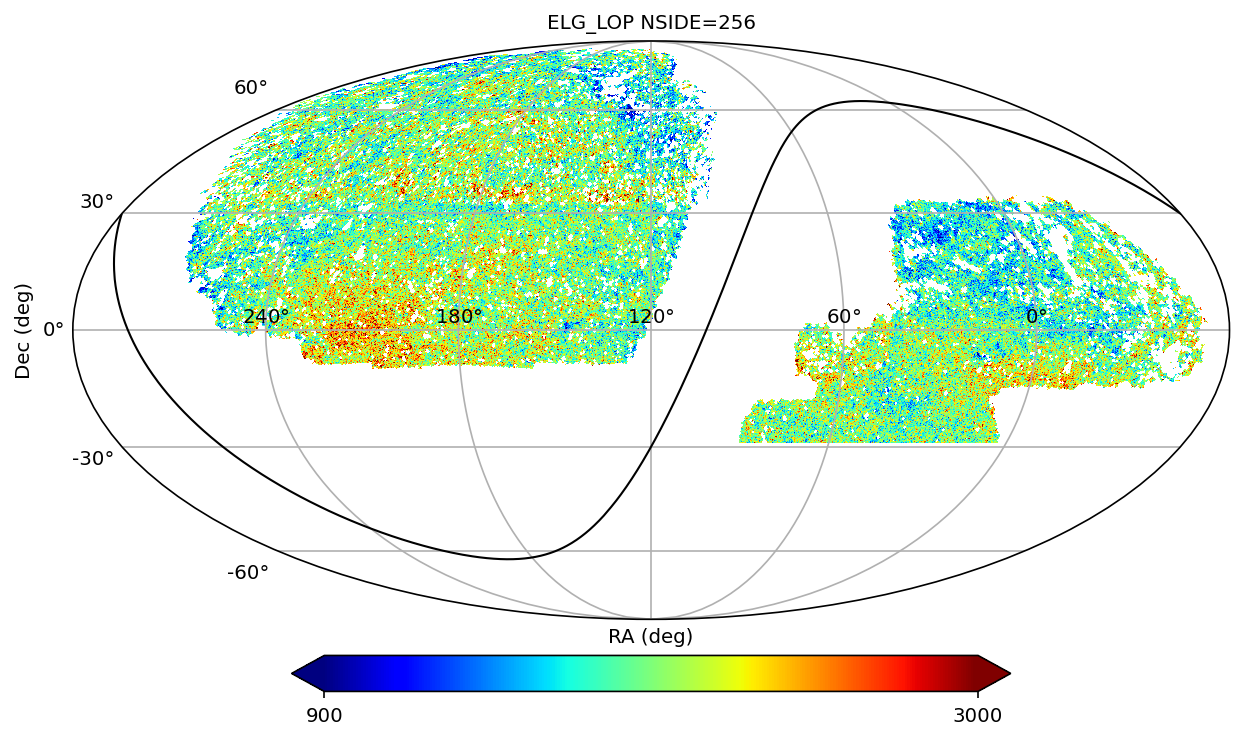

In [4]:
bad_pixels = Table.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/ism_mask/bad_pixels_v1_512_ring.fits')['HPXPIXEL']

npix = hp.nside2npix(512)
tmp = np.zeros(npix)
tmp[bad_pixels] = 1.
tmp = hp.ud_grade(tmp, 256, order_in='RING', order_out='RING')
# bad_pixels_128 = np.where(tmp!=0)[0]
bad_pixels_128 = np.where(tmp>0.2)[0]

nside = 256
target_ver_str = '1.1.1'
pixmap_dir = '/global/cfs/cdirs/desi/users/rongpu/data/imaging_sys/randoms_stats/0.49.0/resolve/combined'
target_densities_dir = '/global/cfs/cdirs/desi/users/rongpu/data/imaging_sys/density_maps/{}/resolve'.format(target_ver_str)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
print(nside, 'Healpix size = {:.5f} sq deg'.format(pix_area))


vrange_dict = {'BGS_ANY': {64: [800, 2000], 128: [650, 2150], 256: [200, 2600], 512: [-200, 3000]},
               'BGS_BRIGHT': {64: [500, 1200], 128: [350, 1350], 256: [200, 1500], 512: [-200, 1800]},
               'LRG': {64: [300, 900], 128: [200, 1000], 256: [100, 1100], 512: [-200, 1400]},
               'ELG': {64: [1200, 3600], 128: [1200, 3600], 256: [1100, 3700], 512: [600, 4200]},
               'ELG_LOP': {64: [1000, 2900], 128: [1000, 2900], 256: [900, 3000], 512: [500, 3400]},
               'QSO': {64: [150, 450], 128: [150, 450], 256: [0, 600], 512: [-200, 800]},
               }


target_class = 'ELG_LOP'
min_nobs = 1
min_pix_frac = 0.4  # minimum fraction of pixel area to be used

maskbits_dict = {'LRG': [], 'ELG': [], 'ELG_LOP': [], 'QSO': [1, 8, 9, 11, 12, 13], 'BGS_ANY': [1, 13], 'BGS_BRIGHT': [1, 13]}
custom_mask_dict = {'LRG': 'lrgmask_v1.1', 'ELG': 'elgmask_v1', 'ELG_LOP': 'elgmask_v1', 'QSO': '', 'BGS_ANY': '', 'BGS_BRIGHT': ''}

maskbits = maskbits_dict[target_class]
custom_mask_name = custom_mask_dict[target_class]

mask_str = ''.join([str(tmp) for tmp in maskbits])
if custom_mask_name!='':
    mask_str += '_' + custom_mask_name

target_class = target_class.lower()
maps_dict = {}

for region in ['BASS+MzLS', 'DECaLS', 'DES']:

    if region=='BASS+MzLS':
        field = 'north'
    else:
        field = 'south'

    density = Table.read(os.path.join(target_densities_dir, 'density_map_{}_{}_nside_{}_minobs_{}_maskbits_{}.fits'.format(target_class, field, nside, min_nobs, mask_str)))
    maps = Table.read(os.path.join(pixmap_dir, 'pixmap_{}_nside_{}_minobs_{}_maskbits_{}.fits'.format(field, nside, min_nobs, mask_str)))
    maps = maps[maps['n_randoms']>0]
    maps = join(maps, density[['HPXPIXEL', 'n_targets']], join_type='outer', keys='HPXPIXEL').filled(0)

    # Load stellar density map
    stardens = np.load('/global/cfs/cdirs/desi/users/rongpu/useful/healpix_maps/pixweight-dr7.1-0.22.0_stardens_{}_ring.npy'.format(nside))
    maps['stardens'] = stardens[maps['HPXPIXEL']]
    maps['stardens_log'] = np.log10(maps['stardens'])

    if field=='south':
        isdes = get_isdes(maps['RA'], maps['DEC'], nside)
        if region=='DES':
            maps = maps[isdes]
        else:
            maps = maps[~isdes]
    maps['region'] = region[:3]
    maps_dict[region] = maps.copy()
            
maps_north = maps_dict['BASS+MzLS']
maps_south = vstack([maps_dict['DECaLS'], maps_dict['DES']])

########## Combine the two maps; proper handling of overlapping pixels ##########

pix_overlap = np.intersect1d(maps_north['HPXPIXEL'], maps_south['HPXPIXEL'])
mask = np.in1d(maps_north['HPXPIXEL'], pix_overlap)
maps_overlap_north = maps_north[mask]
maps_north = maps_north[~mask]
mask = np.in1d(maps_south['HPXPIXEL'], pix_overlap)
maps_overlap_south = maps_south[mask]
maps_south = maps_south[~mask]

maps_overlap_north.sort('HPXPIXEL')
maps_overlap_south.sort('HPXPIXEL')

maps_overlap = maps_overlap_south.copy()
maps_overlap['n_targets'] = maps_overlap_north['n_targets'] + maps_overlap_south['n_targets']
maps_overlap['FRACAREA'] = maps_overlap_north['FRACAREA'] + maps_overlap_south['FRACAREA']

maps = vstack([maps_north, maps_south, maps_overlap])

######################################################################

print(len(maps))

area = np.sum(maps['FRACAREA'])*pix_area
print('Area = {:.1f} sq deg'.format(area))

mask = maps['FRACAREA']>min_pix_frac
maps = maps[mask]

maps['density'] = maps['n_targets'] / (pix_area * maps['FRACAREA'])

mask = ~np.in1d(maps['HPXPIXEL'], bad_pixels_128)
print(np.sum(mask)/len(mask))
maps = maps[mask]
print('maps', len(maps))

mask = maps['DEC']>-29
maps = maps[mask]

plot_map(nside, maps['HPXPIXEL'], maps['density'],
         vmin=vrange_dict[target_class.upper()][nside][0], vmax=vrange_dict[target_class.upper()][nside][1],
         title='{} NSIDE={}'.format(target_class.upper(), nside), save_path='tmp.png', show=False, xsize=1500, dpi=150)
Image("tmp.png")

-------

In [15]:
# cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/truth/cosmos_truth_clean.fits'))
cat = Table(fitsio.read('/global/cfs/cdirs/cosmo/work/legacysurvey/dr10-deep/cosmos/catalogs/cosmos.fits', columns=['ebv', 'galdepth_g', 'galdepth_r', 'galdepth_i', 'galdepth_z']))

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['galdepth_gmag_ebv'] = -2.5*(np.log10((5/np.sqrt(cat['galdepth_g'])))-9) - 3.214*cat['ebv']
    cat['galdepth_rmag_ebv'] = -2.5*(np.log10((5/np.sqrt(cat['galdepth_r'])))-9) - 2.165*cat['ebv']
    cat['galdepth_imag_ebv'] = -2.5*(np.log10((5/np.sqrt(cat['galdepth_i'])))-9) - 1.592*cat['ebv']
    cat['galdepth_zmag_ebv'] = -2.5*(np.log10((5/np.sqrt(cat['galdepth_z'])))-9) - 1.211*cat['ebv']

In [17]:
des_depths = {'g': 24.89, 'r': 24.7, 'z': 23.45}
des_depths['i'] = 24.0  # this is not the actual DES depth
min_depths = {}
for band in ['g', 'r', 'i', 'z']:
    min_depths[band] = des_depths[band] + 1.
print(min_depths)

mask = np.full(len(cat), True)
for band in ['g', 'r', 'i', 'z']:
    mask &= cat['galdepth_{}mag_ebv'.format(band)] > min_depths[band]
cat = cat[mask]
print(len(cat), np.sum(mask)/len(mask))

{'g': 25.89, 'r': 25.7, 'i': 25.0, 'z': 24.45}
1494971 0.36953777960586487


26.297432
26.303846
25.164982


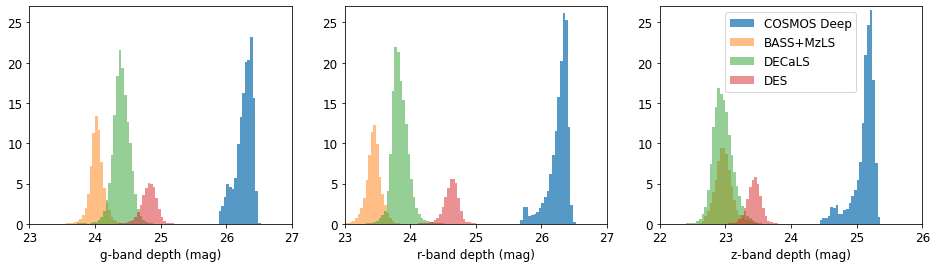

In [18]:
print(np.median(cat['galdepth_gmag_ebv']))
print(np.median(cat['galdepth_rmag_ebv']))
print(np.median(cat['galdepth_zmag_ebv']))

fig, axes = plt.subplots(1, 3, figsize=(16, 4.))
ax = axes[0]
ax.hist(cat['galdepth_gmag_ebv'], 100, range=(23., 27.), alpha=0.75, density=False, weights=np.full(len(cat), 1e-4), label='COSMOS Deep')
for region in ['BASS+MzLS', 'DECaLS', 'DES']:
    mask = (maps['region']==region[:3]) & np.isfinite(maps['galdepth_gmag_ebv'])
    ax.hist(maps['galdepth_gmag_ebv'][mask], 100, range=(23., 27.), alpha=0.5, density=False, weights=np.full(np.sum(mask), 1e-3), label=region)
ax.set_xlim(23., 27.)
ax.set_ylim(0, 27)
ax.set_xlabel('g-band depth (mag)')

ax = axes[1]
ax.hist(cat['galdepth_rmag_ebv'], 100, range=(23., 27), alpha=0.75, density=False, weights=np.full(len(cat), 1e-4), label='COSMOS Deep')
for region in ['BASS+MzLS', 'DECaLS', 'DES']:
    mask = (maps['region']==region[:3]) & np.isfinite(maps['galdepth_rmag_ebv'])
    ax.hist(maps['galdepth_rmag_ebv'][mask], 100, range=(23., 27), alpha=0.5, density=False, weights=np.full(np.sum(mask), 1e-3), label=region)
ax.set_xlim(23., 27)
ax.set_ylim(0, 27)
ax.set_xlabel('r-band depth (mag)')

ax = axes[2]
ax.hist(cat['galdepth_zmag_ebv'], 100, range=(22., 26.), alpha=0.75, density=False, weights=np.full(len(cat), 1e-4), label='COSMOS Deep')
for region in ['BASS+MzLS', 'DECaLS', 'DES']:
    mask = (maps['region']==region[:3]) & np.isfinite(maps['galdepth_zmag_ebv'])
    ax.hist(maps['galdepth_zmag_ebv'][mask], 100, range=(22., 26.), alpha=0.5, density=False, weights=np.full(np.sum(mask), 1e-3), label=region)
ax.set_xlim(22., 26.)
ax.set_ylim(0, 27)
ax.set_xlabel('z-band depth (mag)')
ax.legend()
plt.show()

__dr9.1.1__

In [19]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/dr9/misc/cosmos_deep_dield_9.1.1.fits', columns=['ebv', 'galdepth_g', 'galdepth_r', 'galdepth_z']))

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['galdepth_gmag_ebv'] = -2.5*(np.log10((5/np.sqrt(cat['galdepth_g'])))-9) - 3.214*cat['ebv']
    cat['galdepth_rmag_ebv'] = -2.5*(np.log10((5/np.sqrt(cat['galdepth_r'])))-9) - 2.165*cat['ebv']
    cat['galdepth_zmag_ebv'] = -2.5*(np.log10((5/np.sqrt(cat['galdepth_z'])))-9) - 1.211*cat['ebv']

In [21]:
mask = np.full(len(cat), True)
for band in ['g']:
    mask &= cat['galdepth_{}mag_ebv'.format(band)] > min_depths[band]
cat = cat[mask]
print(len(cat), np.sum(mask)/len(mask))

1048913 0.1622717390614903


26.034016
23.905773
22.942812


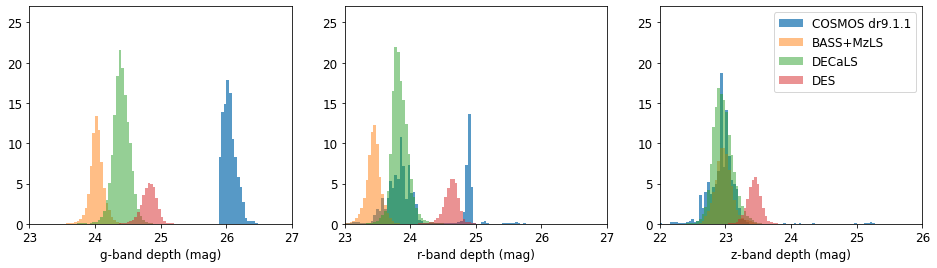

In [22]:
print(np.median(cat['galdepth_gmag_ebv']))
print(np.median(cat['galdepth_rmag_ebv']))
print(np.median(cat['galdepth_zmag_ebv']))

fig, axes = plt.subplots(1, 3, figsize=(16, 4.))
ax = axes[0]
ax.hist(cat['galdepth_gmag_ebv'], 100, range=(23., 27.), alpha=0.75, density=False, weights=np.full(len(cat), 1e-4), label='COSMOS dr9.1.1')
for region in ['BASS+MzLS', 'DECaLS', 'DES']:
    mask = (maps['region']==region[:3]) & np.isfinite(maps['galdepth_gmag_ebv'])
    ax.hist(maps['galdepth_gmag_ebv'][mask], 100, range=(23., 27.), alpha=0.5, density=False, weights=np.full(np.sum(mask), 1e-3), label=region)
ax.set_xlim(23., 27.)
ax.set_ylim(0, 27)
ax.set_xlabel('g-band depth (mag)')

ax = axes[1]
ax.hist(cat['galdepth_rmag_ebv'], 100, range=(23., 27), alpha=0.75, density=False, weights=np.full(len(cat), 1e-4), label='COSMOS dr9.1.1')
for region in ['BASS+MzLS', 'DECaLS', 'DES']:
    mask = (maps['region']==region[:3]) & np.isfinite(maps['galdepth_rmag_ebv'])
    ax.hist(maps['galdepth_rmag_ebv'][mask], 100, range=(23., 27), alpha=0.5, density=False, weights=np.full(np.sum(mask), 1e-3), label=region)
ax.set_xlim(23., 27)
ax.set_ylim(0, 27)
ax.set_xlabel('r-band depth (mag)')

ax = axes[2]
ax.hist(cat['galdepth_zmag_ebv'], 100, range=(22., 26.), alpha=0.75, density=False, weights=np.full(len(cat), 1e-4), label='COSMOS dr9.1.1')
for region in ['BASS+MzLS', 'DECaLS', 'DES']:
    mask = (maps['region']==region[:3]) & np.isfinite(maps['galdepth_zmag_ebv'])
    ax.hist(maps['galdepth_zmag_ebv'][mask], 100, range=(22., 26.), alpha=0.5, density=False, weights=np.full(np.sum(mask), 1e-3), label=region)
ax.set_xlim(22., 26.)
ax.set_ylim(0, 27)
ax.set_xlabel('z-band depth (mag)')
ax.legend()
plt.show()